Benjamin Ye  
CS/CNE/EE 156a: Learning Systems (Fall 2023)  
December 1, 2023

## Final Exam

In [25]:
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import requests
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

mpl.rcParams.update(
    {
        "axes.labelsize": 14,
        "figure.autolayout": True,
        "figure.figsize": (4.875, 3.65625),
        "font.size": 12,
        "legend.columnspacing": 1,
        "legend.edgecolor": "1",
        "legend.framealpha": 0,
        "legend.fontsize": 12,
        "legend.handlelength": 1.25,
        "legend.labelspacing": 0.25,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "text.usetex": True
    }
)

CWD = globals()['_dh'][0].resolve()
sys.path.insert(0, str(CWD.parent))
from cs156a import validate_binary, linear_regression

DATA_DIR = (CWD.parent / "data").resolve()

rng = np.random.default_rng()

### Regularized Linear Regression

In [2]:
DATA_DIR.mkdir(exist_ok=True)
data = {}
for dataset in ["train", "test"]:
    file = f"features.{dataset}"
    if not (DATA_DIR / file).exists():
        r = requests.get(f"http://www.amlbook.com/data/zip/{file}")
        with open(DATA_DIR / file, "wb") as f:
            f.write(r.content)
    data[dataset] = np.loadtxt(DATA_DIR / file)

### Problems 7–10

In [24]:
print("\n[FE P7–9]\nLinear regression with regularization statistics:")
transform = lambda x: np.hstack((x, x[:, 1:2] * x[:, 2:], x[:, 1:2] ** 2, 
                                 x[:, 2:] ** 2))
for digit in range(10):
    x = np.hstack((np.ones((len(data["train"]), 1), dtype=float), 
                   data["train"][:, 1:]))
    y = 2 * (data["train"][:, 0] == digit) - 1
    x_test = np.hstack((np.ones((len(data["test"]), 1), dtype=float), 
                        data["test"][:, 1:]))
    y_test = 2 * (data["test"][:, 0] == digit) - 1
    print(f"  {digit} vs. all:")
    for t, l in zip((None, transform), ("X", "Z")):
        E_in, E_out = linear_regression(
            vf=validate_binary, x=x, y=y, transform=t, 
            regularization="weight_decay", wd_lambda=1,
            x_test=x_test, y_test=y_test, rng=rng
        )
        print(f"    {l}: {E_in=:.6f}, {E_out=:.6f}")

print("\n[FE P10]\nLinear regression with transform and "
      "regularization for 1 vs. 5 classifier statistics:")
subset = data["train"][np.isin(data["train"][:, 0], (1, 5))]
x = np.hstack((np.ones((len(subset), 1), dtype=float), subset[:, 1:]))
y = (subset[:, 0] == 1).astype(int) - (subset[:, 0] == 5)
subset_test = data["test"][np.isin(data["test"][:, 0], (1, 5))]
x_test = np.hstack((np.ones((len(subset_test), 1), dtype=float),
                    subset_test[:, 1:]))
y_test = (subset_test[:, 0] == 1).astype(int) - (subset_test[:, 0] == 5)
for wd_lambda in (0.01, 1):
    E_in, E_out = linear_regression(
        vf=validate_binary, x=x, y=y, transform=transform, 
        regularization="weight_decay", wd_lambda=wd_lambda, 
        x_test=x_test, y_test=y_test, rng=rng
    )
    print(f"    lambda={wd_lambda}: {E_in=:.6f}, {E_out=:.6f}")


[FE P7–9]
Linear regression with regularization statistics:
  0 vs. all:
    X: E_in=0.109313, E_out=0.115097
    Z: E_in=0.102318, E_out=0.106627
  1 vs. all:
    X: E_in=0.015224, E_out=0.022422
    Z: E_in=0.012344, E_out=0.021923
  2 vs. all:
    X: E_in=0.100261, E_out=0.098655
    Z: E_in=0.100261, E_out=0.098655
  3 vs. all:
    X: E_in=0.090248, E_out=0.082711
    Z: E_in=0.090248, E_out=0.082711
  4 vs. all:
    X: E_in=0.089425, E_out=0.099651
    Z: E_in=0.089425, E_out=0.099651
  5 vs. all:
    X: E_in=0.076258, E_out=0.079721
    Z: E_in=0.076258, E_out=0.079223
  6 vs. all:
    X: E_in=0.091071, E_out=0.084704
    Z: E_in=0.091071, E_out=0.084704
  7 vs. all:
    X: E_in=0.088465, E_out=0.073244
    Z: E_in=0.088465, E_out=0.073244
  8 vs. all:
    X: E_in=0.074338, E_out=0.082711
    Z: E_in=0.074338, E_out=0.082711
  9 vs. all:
    X: E_in=0.088328, E_out=0.088191
    Z: E_in=0.088328, E_out=0.088191

[FE P10]
Linear regression with transform and regularization for 1 v

### Problems 11–12

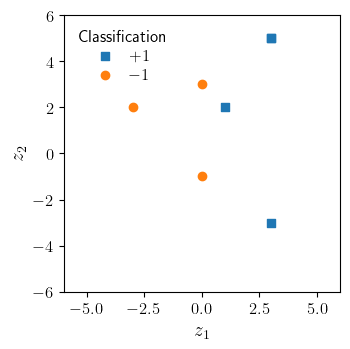

In [60]:
x = np.array(((1, 0), (0, 1), (0, -1), (-1, 0), (0, 2), (0, -2), 
              (-2, 0)), dtype=float)
y = np.array((-1, -1, -1, 1, 1, 1, 1), dtype=int)
z = np.hstack((x[:, 1:] ** 2 - 2 * x[:, :1] - 1, x[:, :1] ** 2 - 2 * x[:, 1:] + 1))

_, ax = plt.subplots()
ax.scatter(*z[y == 1].T, marker="s", label="$+1$")
ax.scatter(*z[y == -1].T, marker="o", label="$-1$")
ax.set_aspect("equal", "box")
ax.set_xlabel("$z_1$")
ax.set_xlim(-6, 6)
ax.set_ylabel("$z_2$")
ax.set_ylim(-6, 6)
ax.legend(title="Classification")
plt.show()